In [16]:
import time
import copy
import numpy as np
from skimage.filters import gaussian_filter
import cv2

%matplotlib inline
%pylab inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab as pl

from tifffile import imread, imsave
import cPickle as pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d

#%matplotlib qt

pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


# Load time-lapse data...

In [17]:
folder = '/Users/jug/Repositories/GIT/BobSeg/AmyMaddox/'
filename = folder + 'Reslice_of_298_crop.tif'

#folder = '/Users/maddox/Jug/Data/'
#filename = folder + 'Reslice_of_298_crop.tif'

stack = imread(filename)
print 'Stack shape:',stack.shape

sigma = [0.,3.,3.]
stack_smooth = gaussian_filter(stack,sigma)

Stack shape: (76, 395, 490)


/usr/local/lib/python2.7/site-packages/skimage/filters/_gaussian.py:22: skimage_deprecation: Function ``gaussian_filter`` is deprecated. Use ``skimage.filters.gaussian`` instead.
  multichannel=None, preserve_range=False, truncate=4.0):


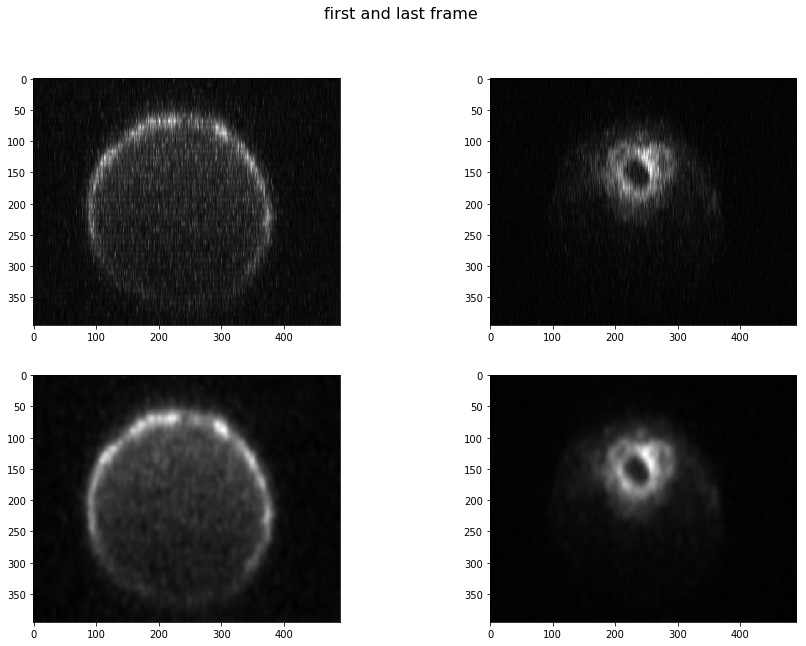

In [18]:
pylab.rcParams['figure.figsize'] = (15, 10)

fig = plt.figure()
fig.suptitle('first and last frame', fontsize=16)
ax = fig.add_subplot(221)
ax.imshow(stack[0], plt.get_cmap('gray'))
ax = fig.add_subplot(222)
ax.imshow(stack[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(223)
ax.imshow(stack_smooth[0], plt.get_cmap('gray'))
ax = fig.add_subplot(224)
ax.imshow(stack_smooth[-1], plt.get_cmap('gray'))

In [19]:
max_rs = (stack[0].shape[1] / 3,
          stack[0].shape[1] / 3)

min_rs = (5,5)
print min_rs, max_rs

(5, 5) (163, 163)


# Adding ring

In [20]:
data = Data3d( stack_smooth, pixelsize=(1.,1.), silent=False )
data.set_seg_params(num_columns=72,K=150,max_delta_k=3)
objects = []

In [21]:
ring = data.init_object("ring")
objects.append(ring)

In [22]:
cx = stack.shape[2] / 2
cy = stack.shape[1] / 2
data.add_object_at( ring, min_rs, max_rs, frame=0, seed=(cx,cy), segment_it=True )
data.track(ring, seed_frame=0, target_frames=range(0,len(data.images)), recenter_iterations=2)

Added appearance for "ring" in frame 0 with seed coordinates [ 245.  197.]
      Optimum energy:  0.244068250719
      Nodes in/out:  9371 1429
      Area:  62103.0
Added appearance for "ring" in frame 0 with seed coordinates [ 245.  197.]
      Optimum energy:  0.244068250719
      Nodes in/out:  9371 1429
      Area:  62103.0
    Updated center to [238 205]
    Updated center to [238 205]
Added appearance for "ring" in frame 1 with seed coordinates [ 238.  205.]
      Optimum energy:  0.235917430796
      Nodes in/out:  9485 1315
      Area:  63201.5
    Updated center to [235 209]
    Updated center to [235 209]
Added appearance for "ring" in frame 2 with seed coordinates [ 235.  209.]
      Optimum energy:  0.210514027573
      Nodes in/out:  9462 1338
      Area:  62786.5
    Updated center to [234 211]
    Updated center to [234 211]
Added appearance for "ring" in frame 3 with seed coordinates [ 234.  211.]
      Optimum energy:  0.197707405536
      Nodes in/out:  9479 1321
    

      Optimum energy:  0.147636462172
      Nodes in/out:  7370 3430
      Area:  38463.0
    Updated center to [252 199]
    Updated center to [252 199]
Added appearance for "ring" in frame 37 with seed coordinates [ 252.  199.]
      Optimum energy:  0.138327705178
      Nodes in/out:  7213 3587
      Area:  36932.0
    Updated center to [251 195]
    Updated center to [251 195]
Added appearance for "ring" in frame 38 with seed coordinates [ 251.  195.]
      Optimum energy:  0.148580900421
      Nodes in/out:  7133 3667
      Area:  36161.0
    Updated center to [250 192]
    Updated center to [250 192]
Added appearance for "ring" in frame 39 with seed coordinates [ 250.  192.]
      Optimum energy:  0.126214312801
      Nodes in/out:  7029 3771
      Area:  35119.5
    Updated center to [250 190]
    Updated center to [250 190]
Added appearance for "ring" in frame 40 with seed coordinates [ 250.  190.]
      Optimum energy:  0.124663249123
      Nodes in/out:  6890 3910
      Area:

Added appearance for "ring" in frame 72 with seed coordinates [ 243.  143.]
      Optimum energy:  0.121897332008
      Nodes in/out:  2148 8652
      Area:  3800.5
    Updated center to [239 144]
    Updated center to [239 144]
Added appearance for "ring" in frame 73 with seed coordinates [ 239.  144.]
      Optimum energy:  0.134708503576
      Nodes in/out:  2050 8750
      Area:  3533.0
    Updated center to [235 145]
    Updated center to [235 145]
Added appearance for "ring" in frame 74 with seed coordinates [ 235.  145.]
      Optimum energy:  0.154079767374
      Nodes in/out:  1951 8849
      Area:  3237.5
    Updated center to [232 146]
    Updated center to [232 146]
Added appearance for "ring" in frame 75 with seed coordinates [ 232.  146.]
      Optimum energy:  0.155554226517
      Nodes in/out:  1676 9124
      Area:  2458.0
    Updated center to [232 148]
    Updated center to [232 148]


In [23]:
data.segment2dt( ring, max_radial_delta=3 )

Results for frame 0:
      Optimum energy:  11.2917694289
      Area:  62507.0
Results for frame 1:
      Optimum energy:  11.2917694289
      Area:  63171.0
Results for frame 2:
      Optimum energy:  11.2917694289
      Area:  62979.5
Results for frame 3:
      Optimum energy:  11.2917694289
      Area:  63117.0
Results for frame 4:
      Optimum energy:  11.2917694289
      Area:  63016.5
Results for frame 5:
      Optimum energy:  11.2917694289
      Area:  62767.0
Results for frame 6:
      Optimum energy:  11.2917694289
      Area:  62685.5
Results for frame 7:
      Optimum energy:  11.2917694289
      Area:  62776.0
Results for frame 8:
      Optimum energy:  11.2917694289
      Area:  62260.0
Results for frame 9:
      Optimum energy:  11.2917694289
      Area:  62036.0
Results for frame 10:
      Optimum energy:  11.2917694289
      Area:  61411.5
Results for frame 11:
      Optimum energy:  11.2917694289
      Area:  61014.5
Results for frame 12:
      Optimum energy:  11.29

# Check results

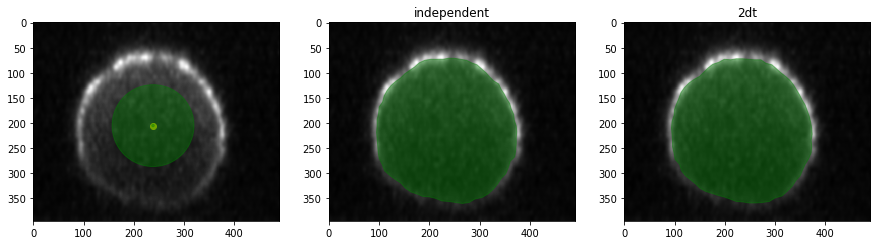

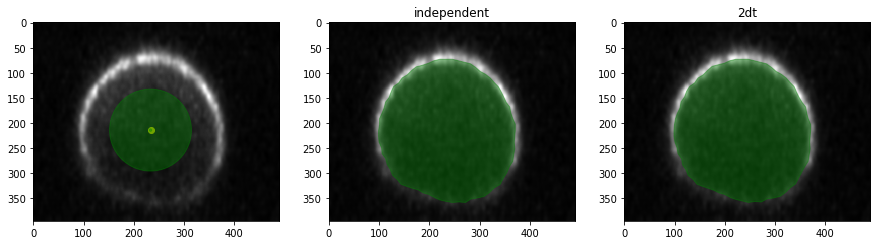

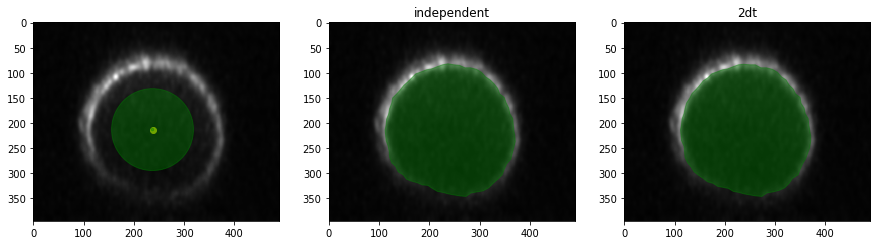

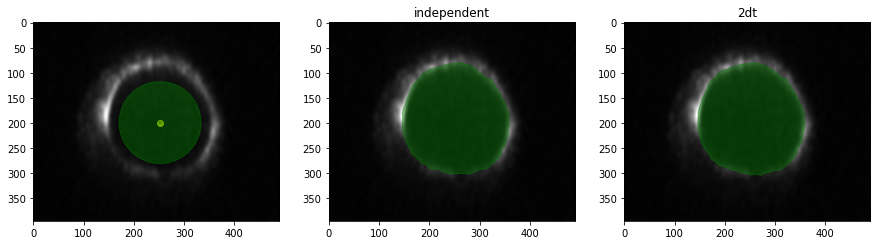

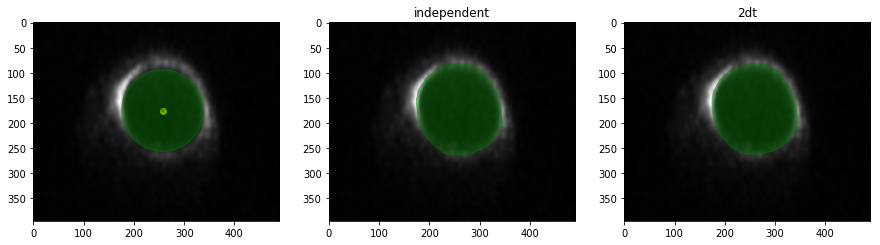

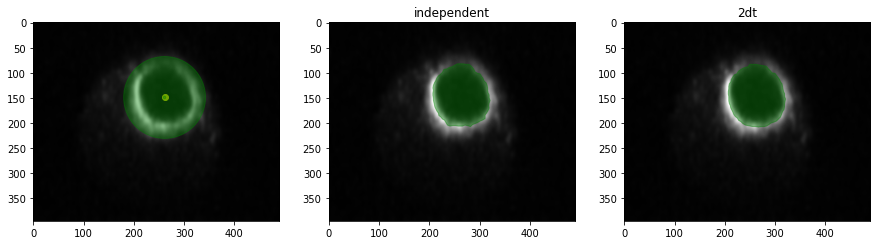

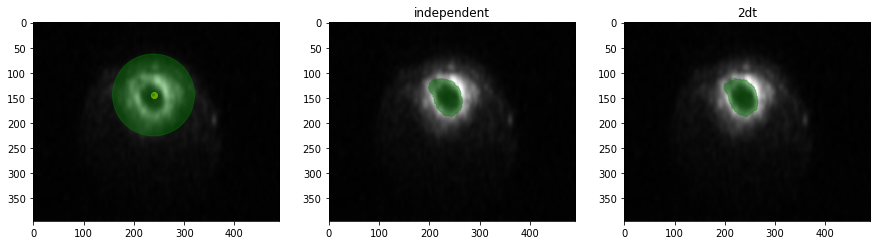

In [24]:
pylab.rcParams['figure.figsize'] = (15, 7)
for frame in range(1,len(data.images),len(data.images)/6):
    fig = plt.figure()
    ax = plt.subplot(131)
    data.plot_minmax( frame, ax )
    ax = plt.subplot(132)
    ax.set_title('independent')
    data.plot_result( frame, ax )    
    ax = plt.subplot(133)
    ax.set_title('2dt')
    data.plot_2dt_result( frame, ax )

# Create and show segmentation movie
_Note:_ this also creates the data you might want to export below... so you cannot skip this step if you are interested in doing so!

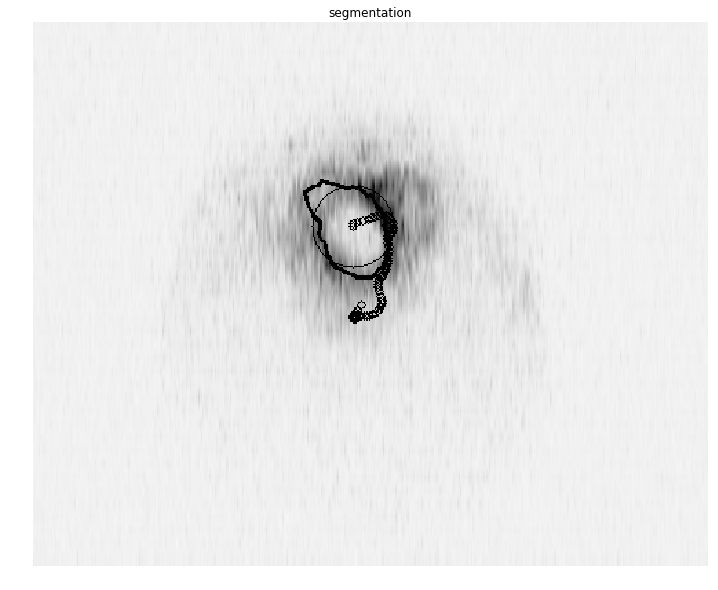

In [25]:
(frames, centers, polygones, radii) = data.draw_segmentation(stack, folder=None, inline=True)

### Store movie frames in a folder

In [19]:
for f in range(len(frames)):
    imsave(folder+'movie_export/frame%02d.tif'%(f), frames[f])

# Store data for later processing
_Note:_ I assume here that you only segmented one single object in your movie (which is not crazy to assume since you will only have one ring in your images, right?). Anyways, if you segmented multiple objects only the first one will be exported...

In [43]:
data_filename = folder+'data.jug'
str_now = datetime.datetime.now().strftime("%B %d, %Y at %I:%M%p")

with open(data_filename, "w") as data_file:
    data_file.write("# Exported after processing '%s' on %s\n\n" % (filename,str_now))
    for t in range(len(frames)):
        data_file.write("t, %d\n"%t)
        data_file.write("COM, %d, %d\n"%(centers[t][0],centers[t][1]))
        polygone = polygones[t][0] # we will only export the first polygone here!
        for p in range(len(polygone)):
            data_file.write("p%d, %d, %d\n"%(p,polygone[p][0],polygone[p][1]))
        data_file.write("\n")